In [ ]:
! pip install votekit

# Math of VoteKit

This notebook is a collection of live demos of VoteKit. This is intended to focus on the underlying math of VoteKit, and should be used as a companion to the "Math of VoteKit" presentation.

# Spatial models




In [2]:
from votekit.ballot_generator import Spatial
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Choose number of voters n
# And the number of candidates m
n = 100
m = 5
candidates = [str(i) for i in range(m)]

# We can use any numpy distribution (or custom distribution -- more on that later)
# to randomly sample  positions for voters and canidates.
# Here we sample from the following distributions distributions
# Voters: Normal(mean = 1/2, std = 1/10) in 2d
# Candidates: Uniform(0,1) in 2d

# Define a dictionary of parameters for both distributions
# for a full list of possible distributions and their
# required parameters check out:
# https://numpy.org/doc/1.16/reference/routines.random.html
voter_params = {"loc": 0.5, "scale": 0.1, "size": 2}
candidate_params = {"low": 0, "high": 1, "size": 2}

# We also define a distance function to compute the
# distances between any pair of voters and candidates.
# Here, we just use euclidean distance
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Now we may pass all of to the Spatial generation method
generator = Spatial(
    candidates=candidates,
    voter_dist=np.random.normal,
    voter_dist_kwargs=voter_params,
    candidate_dist=np.random.uniform,
    candidate_dist_kwargs=candidate_params,
    distance=distance,
)

# Generate a profile from random candidate and voter positions
profile, candidate_position_dict, voter_positions = generator.generate_profile(
    number_of_ballots=n
)

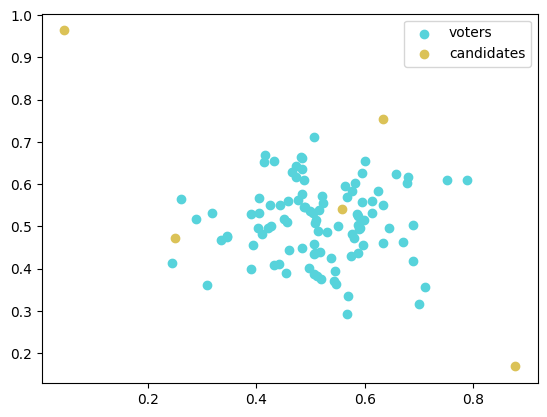

In [4]:
# And then visualize the results
candidate_positions = np.array([i for i in candidate_position_dict.values()])
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:, 0], voter_positions[:, 1], label="voters", color=pal[4])
plt.scatter(
    candidate_positions[:, 0],
    candidate_positions[:, 1],
    label="candidates",
    color=pal[1],
)
plt.legend()

# IC, IAC


IC profile:
             Ranking_1 Ranking_2 Ranking_3 Voter Set  Weight
Ballot Index                                                
0                  (A)       (C)       (B)        {}   162.0
1                  (C)       (A)       (B)        {}   183.0
2                  (C)       (B)       (A)        {}   158.0
3                  (A)       (B)       (C)        {}   162.0
4                  (B)       (C)       (A)        {}   168.0
5                  (B)       (A)       (C)        {}   167.0


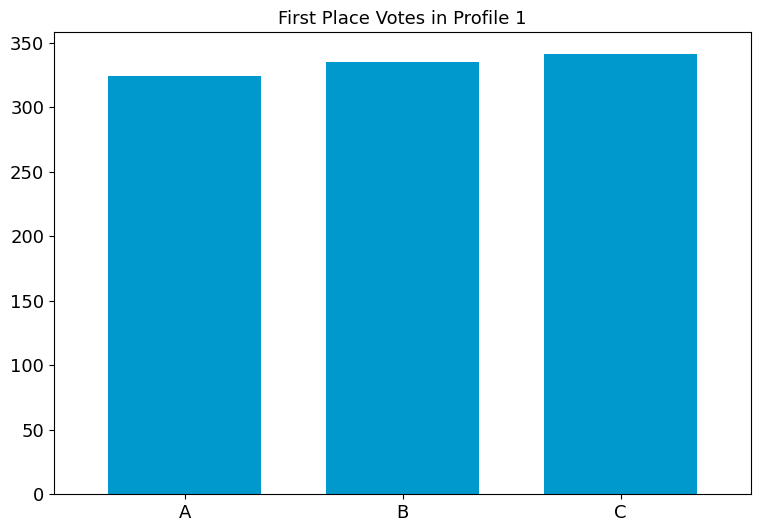

In [10]:
from votekit.plots import multi_profile_fpv_plot, profile_fpv_plot
import votekit.ballot_generator as bg

# generate a profile to work with first
candidates = ["A", "B", "C"]

# initializing the ballot generator
ic = bg.ImpartialCulture(candidates=candidates)


profile1 = ic.generate_profile(number_of_ballots=1000)


print("IC profile:")
print(profile1.df)

fig1 = profile_fpv_plot(profile1, title="First Place Votes in Profile 1", candidate_ordering=["A", "B", "C"])

IC profile:
             Ranking_1 Ranking_2 Ranking_3 Voter Set  Weight
Ballot Index                                                
0                  (B)       (A)       (C)        {}   440.0
1                  (A)       (B)       (C)        {}   328.0
2                  (A)       (C)       (B)        {}   105.0
3                  (C)       (B)       (A)        {}    65.0
4                  (B)       (C)       (A)        {}    14.0
5                  (C)       (A)       (B)        {}    48.0


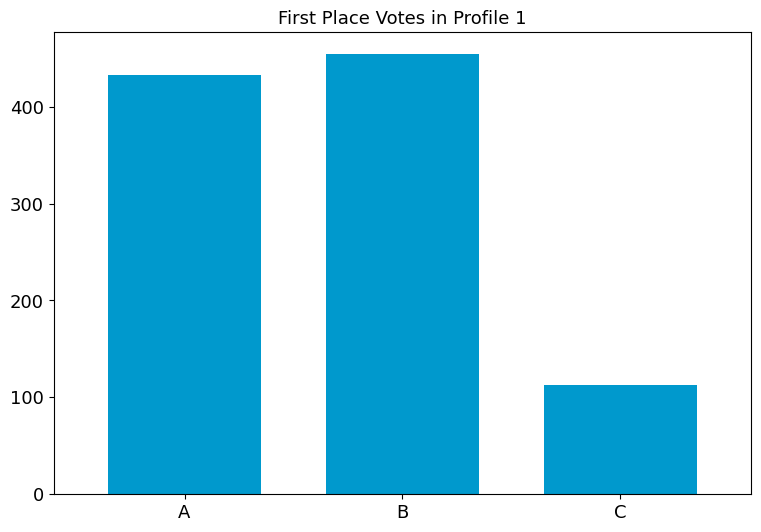

In [9]:
iac = bg.ImpartialAnonymousCulture(candidates=candidates)
profile2 = iac.generate_profile(number_of_ballots=1000)

print("IC profile:")
print(profile2.df)

fig2 = profile_fpv_plot(profile2, title="First Place Votes in Profile 1", candidate_ordering=["A", "B", "C"])



# dirichlet for Pref Intervals


In [21]:
from votekit.pref_interval import PreferenceInterval

strong_pref_interval = PreferenceInterval.from_dirichlet(
    candidates=["A", "B", "C"], alpha=0.1
)
print("Strong preference for one candidate", {c: f"{x:.2f}" for c,x in strong_pref_interval.interval.items()})

abo_pref_interval = PreferenceInterval.from_dirichlet(
    candidates=["A", "B", "C"], alpha=1
)
print("All bets are off preference", {c: f"{x:.2f}" for c,x in abo_pref_interval.interval.items()})

unif_pref_interval = PreferenceInterval.from_dirichlet(
    candidates=["A", "B", "C"], alpha=10
)
print("Uniform preference for all candidates", {c: f"{x:.2f}" for c,x in unif_pref_interval.interval.items()})

Strong preference for one candidate {'A': '0.00', 'B': '0.00', 'C': '1.00'}
All bets are off preference {'A': '0.12', 'B': '0.03', 'C': '0.85'}
Uniform preference for all candidates {'A': '0.22', 'B': '0.36', 'C': '0.42'}



# PL, BT


In [23]:
import votekit.ballot_generator as bg
from votekit import PreferenceInterval

# the sPL model assumes there are blocs of voters,
# but we can just say that there is only one bloc
bloc_voter_prop = {"all_voters": 1}
slate_to_candidates = {"all_voters": ["A", "B", "C"]}

# the preference interval (80,15,5)
pref_intervals_by_bloc = {
    "all_voters": {"all_voters": PreferenceInterval({"A": 0.80, "B": 0.15, "C": 0.05})}
}

# the sPL model needs an estimate of cohesion between blocs,
# but there is only one bloc here
cohesion_parameters = {"all_voters": {"all_voters": 1}}

pl = bg.slate_PlackettLuce(
    pref_intervals_by_bloc=pref_intervals_by_bloc,
    bloc_voter_prop=bloc_voter_prop,
    slate_to_candidates=slate_to_candidates,
    cohesion_parameters=cohesion_parameters,
)

profile = pl.generate_profile(number_of_ballots=100)
print(profile.df)

             Ranking_1 Ranking_2 Ranking_3 Voter Set  Weight
Ballot Index                                                
0                  (A)       (B)       (C)        {}    56.0
1                  (A)       (C)       (B)        {}    21.0
2                  (B)       (C)       (A)        {}     1.0
3                  (B)       (A)       (C)        {}    15.0
4                  (C)       (A)       (B)        {}     7.0


In [24]:
slate_to_candidates = {"Alpha": ["A", "B"], "Xenon": ["X", "Y"]}

# note that we include candidates with 0 support,
# and that our preference intervals will automatically rescale to sum to 1

pref_intervals_by_bloc = {
    "Alpha": {
        "Alpha": PreferenceInterval({"A": 0.8, "B": 0.2}),
        "Xenon": PreferenceInterval({"X": 0, "Y": 1}),
    },
    "Xenon": {
        "Alpha": PreferenceInterval({"A": 0.5, "B": 0.5}),
        "Xenon": PreferenceInterval({"X": 0.5, "Y": 0.5}),
    },
}


bloc_voter_prop = {"Alpha": 0.8, "Xenon": 0.2}

# assume that each bloc is 90% cohesive
# we'll discuss exactly what that means later
cohesion_parameters = {
    "Alpha": {"Alpha": 0.9, "Xenon": 0.1},
    "Xenon": {"Xenon": 0.9, "Alpha": 0.1},
}

pl = bg.slate_BradleyTerry(
    pref_intervals_by_bloc=pref_intervals_by_bloc,
    bloc_voter_prop=bloc_voter_prop,
    slate_to_candidates=slate_to_candidates,
    cohesion_parameters=cohesion_parameters,
)

# the by_bloc parameter allows us to see which ballots came from which blocs of voters
profile_dict, agg_profile = pl.generate_profile(number_of_ballots=10000, by_bloc=True)
print("The ballots from Alpha voters\n", profile_dict["Alpha"].df)

print("The ballots from Xenon voters\n", profile_dict["Xenon"].df)

print("Aggregated ballots\n", agg_profile.df)

The ballots from Alpha voters
              Ranking_1 Ranking_2 Ranking_3 Ranking_4  Weight Voter Set
Ballot Index                                                          
0                  (A)       (B)       (Y)       (X)  5699.0        {}
1                  (A)       (Y)       (B)       (X)   654.0        {}
2                  (B)       (A)       (Y)       (X)  1400.0        {}
3                  (B)       (Y)       (A)       (X)   155.0        {}
4                  (Y)       (B)       (A)       (X)    15.0        {}
5                  (Y)       (A)       (B)       (X)    77.0        {}
The ballots from Xenon voters
              Ranking_1 Ranking_2 Ranking_3 Ranking_4  Weight Voter Set
Ballot Index                                                          
0                  (Y)       (X)       (A)       (B)   461.0        {}
1                  (Y)       (X)       (B)       (A)   450.0        {}
2                  (Y)       (A)       (B)       (X)     8.0        {}
3              


# CS


In [25]:
bloc_voter_prop = {"W": 0.8, "C": 0.2}

# the values of .9 indicate that these blocs are highly polarized;
# they prefer their own candidates much more than the opposing slate
cohesion_parameters = {"W": {"W": 0.9, "C": 0.1}, "C": {"C": 0.9, "W": 0.1}}

alphas = {"W": {"W": 2, "C": 1}, "C": {"W": 1, "C": 0.5}}

slate_to_candidates = {"W": ["W1", "W2", "W3"], "C": ["C1", "C2"]}

cs = bg.CambridgeSampler.from_params(
    slate_to_candidates=slate_to_candidates,
    bloc_voter_prop=bloc_voter_prop,
    cohesion_parameters=cohesion_parameters,
    alphas=alphas,
)


profile = cs.generate_profile(number_of_ballots=1000)
print(profile.df.head(10).to_string())

             Ranking_1 Ranking_2 Ranking_3 Ranking_4 Ranking_5 Voter Set  Weight
Ballot Index                                                                    
0                 (W3)      (C1)      (C2)      (W1)      (W2)        {}     3.0
1                 (W3)      (C1)      (C2)      (W1)       (~)        {}     1.0
2                 (W3)      (C1)      (C2)      (W2)      (W1)        {}     2.0
3                 (W3)      (C1)      (W2)      (W1)      (C2)        {}     2.0
4                 (W3)      (C1)      (W1)      (C2)      (W2)        {}     1.0
5                 (W3)      (C1)      (W1)      (W2)       (~)        {}     2.0
6                 (W3)      (C1)      (W1)      (W2)      (C2)        {}     6.0
7                 (W3)      (C1)       (~)       (~)       (~)        {}     2.0
8                 (W3)      (W2)      (W1)       (~)       (~)        {}     4.0
9                 (W3)      (W2)      (W1)      (C1)      (C2)        {}     1.0
